In [9]:
import tensorflow as tf
import numpy as np
import os

# Define the image dimensions and batch size
img_height = 256
img_width = 256
batch_size = 32 # Increased batch size for potentially faster training

# Define the directories for training and testing data
train_dir = os.path.join(os.getcwd(), "data", "train")
test_dir = os.path.join(os.getcwd(), "data", "test")

# Load the training dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='int',
    image_size=(img_height, img_width),
    interpolation='nearest',
    batch_size=batch_size,
    shuffle=True
)

# Load the testing dataset
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='int',
    image_size=(img_height, img_width),
    interpolation='nearest',
    batch_size=batch_size,
    shuffle=False # No need to shuffle test data
)

# Get the class names
class_names = train_ds.class_names
print("Class names:", class_names)

# Display the number of batches in the datasets
print("Number of training batches:", tf.data.experimental.cardinality(train_ds).numpy())
print("Number of testing batches:", tf.data.experimental.cardinality(test_ds).numpy())

Found 5200 files belonging to 2 classes.
Found 1416 files belonging to 2 classes.
Class names: ['Fraud', 'Non-Fraud']
Number of training batches: 163
Number of testing batches: 45
Found 1416 files belonging to 2 classes.
Class names: ['Fraud', 'Non-Fraud']
Number of training batches: 163
Number of testing batches: 45


Next, we will analyze and address the class imbalance.

In [10]:
# Analyze class distribution in the training data
fraud_count = 0
non_fraud_count = 0
num_classes = 2  # Set explicitly since Colab sometimes inferred this from context

for images, labels in train_ds:
    fraud_count += tf.reduce_sum(tf.cast(labels == 0, tf.int32)).numpy()
    non_fraud_count += tf.reduce_sum(tf.cast(labels == 1, tf.int32)).numpy()

total_samples = fraud_count + non_fraud_count

print(f"Fraud samples in training data: {fraud_count}")
print(f"Non-fraud samples in training data: {non_fraud_count}")
print(f"Total samples in training data: {total_samples}")

# Calculate class weights to handle imbalance
# The 'fraud' class is 0 and 'non fraud' is 1 based on the directory loading order
weight_for_0 = (total_samples / (num_classes * fraud_count)) if fraud_count > 0 else 1.0
weight_for_1 = (total_samples / (num_classes * non_fraud_count)) if non_fraud_count > 0 else 1.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print("Class weights:", class_weight)

2025-09-14 00:09:34.885048: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:18: Filling up shuffle buffer (this may take a while): 37 of 256
2025-09-14 00:09:52.425029: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.
2025-09-14 00:09:52.425029: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


Fraud samples in training data: 200
Non-fraud samples in training data: 5000
Total samples in training data: 5200
Class weights: {0: 13.0, 1: 0.52}


Now, we will set up the data augmentation layers.

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# Create a data augmentation sequence
data_augmentation = Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(0.2),
  layers.RandomContrast(0.2),
])

Now, we will build the first model using transfer learning with EfficientNetV2-B0.

In [14]:
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# Create the base model from the pre-trained EfficientNetV2B0 model
base_model_effnet = EfficientNetV2B0(input_shape=(img_height, img_width, 3),
                                     include_top=False,
                                     weights='imagenet')

# Freeze the base model to prevent its weights from being updated during training
base_model_effnet.trainable = False

# Build the model on top of the base model
model_effnet = Sequential([
    data_augmentation,
    base_model_effnet,
    layers.GlobalAveragePooling2D(),
    layers.Dense(1, activation='sigmoid') # Output layer for binary classification
])

# Compile the model
model_effnet.compile(optimizer='adam',
                     loss='binary_crossentropy', # Using binary crossentropy for binary classification
                     metrics=['accuracy'])

# Display the model summary
model_effnet.build((None, img_height, img_width, 3))
model_effnet.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 efficientnetv2-b0 (Functio  (None, 8, 8, 1280)        5919312   
 nal)                                                            
                                                                 
 global_average_pooling2d_3  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_3 (Dense)             (None, 1)                 1281      
                                                                 
Total params: 5920593 (22.59 MB)
Trainable params: 1281 (5.00 KB)
Non-trainable params: 5919312 (22.58 MB)
_________________________________________________________________


Now, we will train the EfficientNetV2-B0 model.

In [15]:
epochs = 10 # You can adjust the number of epochs
history_effnet = model_effnet.fit(
    train_ds,
    epochs=epochs,
    class_weight=class_weight,
    validation_data=test_ds # Use test_ds as validation data for monitoring
)

Epoch 1/10
163/163 [==============================] - 460s 3s/step - loss: 0.5650 - accuracy: 0.7137 - val_loss: 0.2833 - val_accuracy: 0.9322
Epoch 2/10
163/163 [==============================] - 96s 587ms/step - loss: 0.4791 - accuracy: 0.7913 - val_loss: 0.3024 - val_accuracy: 0.9138
Epoch 3/10
163/163 [==============================] - 93s 568ms/step - loss: 0.4266 - accuracy: 0.8179 - val_loss: 0.2230 - val_accuracy: 0.9350
Epoch 4/10
163/163 [==============================] - 91s 554ms/step - loss: 0.3921 - accuracy: 0.8362 - val_loss: 0.2088 - val_accuracy: 0.9371
Epoch 5/10
163/163 [==============================] - 91s 555ms/step - loss: 0.3991 - accuracy: 0.8229 - val_loss: 0.2509 - val_accuracy: 0.9230
Epoch 6/10
163/163 [==============================] - 95s 578ms/step - loss: 0.3848 - accuracy: 0.8390 - val_loss: 0.2441 - val_accuracy: 0.9251
Epoch 7/10
163/163 [==============================] - 92s 562ms/step - loss: 0.3851 - accuracy: 0.8390 - val_loss: 0.2709 - val_accu

Now, we will build the second model using transfer learning with ResNet50.

In [20]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# Create the base model from the pre-trained ResNet50 model
base_model_resnet = ResNet50(input_shape=(img_height, img_width, 3),
                             include_top=False,
                             weights='imagenet')

# Freeze the base model
base_model_resnet.trainable = False

# Build the model on top of the base model
model_resnet = Sequential([
    data_augmentation,
    base_model_resnet,
    layers.GlobalAveragePooling2D(),
    layers.Dense(1, activation='sigmoid') # Output layer for binary classification
])

# Compile the model
model_resnet.compile(optimizer='adam',
                     loss='binary_crossentropy',
                     metrics=['accuracy'])

# Display the model summary
model_resnet.build((None, img_height, img_width, 3))
model_resnet.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 global_average_pooling2d_8  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_8 (Dense)             (None, 1)                 2049      
                                                                 
Total params: 23589761 (89.99 MB)
Trainable params: 2049 (8.00 KB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


Now, we will train the ResNet50 model.

In [24]:
epochs = 10 # You can adjust the number of epochs
history_resnet = model_resnet.fit(
    train_ds,
    epochs=epochs,
    class_weight=class_weight,
    validation_data=test_ds # Use test_ds as validation data for monitoring
)

Epoch 1/10
163/163 [==============================] - 274s 2s/step - loss: 0.4462 - accuracy: 0.7952 - val_loss: 0.4238 - val_accuracy: 0.8107
Epoch 2/10
163/163 [==============================] - 273s 2s/step - loss: 0.4079 - accuracy: 0.8200 - val_loss: 0.4073 - val_accuracy: 0.8242
Epoch 3/10
163/163 [==============================] - 273s 2s/step - loss: 0.3909 - accuracy: 0.8269 - val_loss: 0.2463 - val_accuracy: 0.9117
Epoch 4/10
163/163 [==============================] - 278s 2s/step - loss: 0.3922 - accuracy: 0.8167 - val_loss: 0.2027 - val_accuracy: 0.9308
Epoch 5/10
163/163 [==============================] - 272s 2s/step - loss: 0.3468 - accuracy: 0.8487 - val_loss: 0.2797 - val_accuracy: 0.8849
Epoch 6/10
163/163 [==============================] - 270s 2s/step - loss: 0.3395 - accuracy: 0.8494 - val_loss: 0.2358 - val_accuracy: 0.9047
Epoch 7/10
163/163 [==============================] - 274s 2s/step - loss: 0.3314 - accuracy: 0.8550 - val_loss: 0.2505 - val_accuracy: 0.8983

Now, we will build the third model using transfer learning with ConvNeXt-Tiny.

In [25]:
from tensorflow.keras.applications import ConvNeXtTiny
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# Create the base model from the pre-trained ConvNeXtTiny model
base_model_convnext = ConvNeXtTiny(input_shape=(img_height, img_width, 3),
                                    include_top=False,
                                    weights='imagenet')

# Freeze the base model
base_model_convnext.trainable = False

# Build the model on top of the base model
model_convnext = Sequential([
    data_augmentation,
    base_model_convnext,
    layers.GlobalAveragePooling2D(),
    layers.Dense(1, activation='sigmoid') # Output layer for binary classification
])

# Compile the model
model_convnext.compile(optimizer='adam',
                       loss='binary_crossentropy',
                       metrics=['accuracy'])

# Display the model summary
model_convnext.build((None, img_height, img_width, 3))
model_convnext.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 convnext_tiny (Functional)  (None, 8, 8, 768)         27820128  
                                                                 
 global_average_pooling2d_1  (None, 768)               0         
 1 (GlobalAveragePooling2D)                                      
                                                                 
 dense_11 (Dense)            (None, 1)                 769       
                                                                 
Total params: 27820897 (106.13 MB)
Trainable params: 769 (3.00 KB)
Non-trainable params: 27820128 (106.13 MB)
_________________________________________________________________


Now, we will train the ConvNeXt-Tiny model.

In [ ]:
epochs = 10 # You can adjust the number of epochs
history_convnext = model_convnext.fit(
    train_ds,
    epochs=epochs,
    class_weight=class_weight,
    validation_data=test_ds # Use test_ds as validation data for monitoring
)

Epoch 1/10


2025-09-14 01:43:40.877087: I external/local_xla/xla/service/service.cc:168] XLA service 0x36603aa00 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2025-09-14 01:43:40.877115: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
I0000 00:00:1757794421.051083       1 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2025-09-14 01:43:41.052319: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.


163/163 [==============================] - 1481s 9s/step - loss: 0.6346 - accuracy: 0.6338 - val_loss: 0.4708 - val_accuracy: 0.8856
Epoch 2/10
163/163 [==============================] - 25002s 154s/step - loss: 0.5334 - accuracy: 0.7817 - val_loss: 0.3491 - val_accuracy: 0.9308
Epoch 3/10
163/163 [==============================] - 1712s 11s/step - loss: 0.4769 - accuracy: 0.8048 - val_loss: 0.3990 - val_accuracy: 0.8821
Epoch 4/10
163/163 [==============================] - 1715s 11s/step - loss: 0.4606 - accuracy: 0.8160 - val_loss: 0.3728 - val_accuracy: 0.8870
Epoch 5/10
163/163 [==============================] - 1546s 9s/step - loss: 0.4436 - accuracy: 0.8338 - val_loss: 0.3103 - val_accuracy: 0.9237
Epoch 6/10
163/163 [==============================] - 1546s 9s/step - loss: 0.4135 - accuracy: 0.8348 - val_loss: 0.3122 - val_accuracy: 0.9174
Epoch 7/10
163/163 [==============================] - 1524s 9s/step - loss: 0.4025 - accuracy: 0.8342 - val_loss: 0.3112 - val_accuracy: 0.916

Now, we will create an ensemble of the trained models.

In [ ]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Average

# Get the inputs of the individual models
input_shape = (img_height, img_width, 3)
input_tensor = Input(shape=input_shape)

# Get the outputs of the individual models (before the final activation if possible, but sigmoid outputs are fine for averaging probabilities)
# We need to apply the data augmentation to the input before feeding it to the base models
augmented_input = data_augmentation(input_tensor)

# Get the output from each trained model's base (unfrozen) part
# We need to remove the data augmentation and the final dense layer from the individual models
model_effnet_base_output = model_effnet.layers[1](augmented_input) # Get output after base_model_effnet
model_resnet_base_output = model_resnet.layers[1](augmented_input) # Get output after base_model_resnet
model_convnext_base_output = model_convnext.layers[1](augmented_input) # Get output after base_model_convnext


# Apply GlobalAveragePooling2D and Dense layers from each model to their respective base outputs
model_effnet_output = model_effnet.layers[2](model_effnet_base_output) # GlobalAveragePooling2D
model_effnet_output = model_effnet.layers[3](model_effnet_output) # Dense

model_resnet_output = model_resnet.layers[2](model_resnet_base_output) # GlobalAveragePooling2D
model_resnet_output = model_resnet.layers[3](model_resnet_output) # Dense

model_convnext_output = model_convnext.layers[2](model_convnext_base_output) # GlobalAveragePooling2D
model_convnext_output = model_convnext.layers[3](model_convnext_output) # Dense


# Average the predictions of the three models
ensemble_output = Average()([model_effnet_output, model_resnet_output, model_convnext_output])

# Create the ensemble model
ensemble_model = Model(inputs=input_tensor, outputs=ensemble_output)

# Compile the ensemble model (optimizer and loss function will be the same as individual models)
ensemble_model.compile(optimizer='adam',
                       loss='binary_crossentropy',
                       metrics=['accuracy'])

# Display the ensemble model summary
ensemble_model.summary()

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_13      │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_2        │ (None, 256, 256,  │          0 │ input_layer_13[0… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ efficientnetv2-b0   │ (None, 8, 8,      │  5,919,312 │ sequential_2[3][… │
│ (Functional)        │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 8, 8,      │ 23,587,712 │ sequential_2[3][… │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_tiny       │ (None, 8, 8, 768) │ 27,820,128 │ sequential_2[3][… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1280)      │          0 │ efficientnetv2-b… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50[1][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 768)       │          0 │ convnext_tiny[1]… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 1)         │      1,281 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 1)         │      2,049 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 1)         │        769 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average (Average)   │ (None, 1)         │          0 │ dense_4[1][0],    │
│                     │                   │            │ dense_5[1][0],    │
│                     │                   │            │ dense_6[1][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 57,331,251 (218.70 MB)

 Trainable params: 4,099 (16.01 KB)

 Non-trainable params: 57,327,152 (218.69 MB)

Now, we will evaluate the performance of the ensemble model on the test data.

In [ ]:
# Evaluate the ensemble model on the test dataset
loss, accuracy = ensemble_model.evaluate(test_ds)

print(f"Ensemble model loss on test data: {loss}")
print(f"Ensemble model accuracy on test data: {accuracy}")

45/45 ━━━━━━━━━━━━━━━━━━━━ 43s 656ms/step - accuracy: 0.9048 - loss: 0.2917
Ensemble model loss on test data: 0.23552414774894714
Ensemble model accuracy on test data: 0.9392655491828918


Now, we will make predictions using the ensemble model on the test data.

In [ ]:
# Get predictions for the test dataset
predictions = ensemble_model.predict(test_ds)

# The predictions are probabilities, convert them to class labels (0 or 1)
# A threshold of 0.5 is commonly used for binary classification
predicted_classes = (predictions > 0.5).astype(int)

# Display some predictions and their corresponding true labels
print("Sample Predictions:")
for i in range(min(10, len(predicted_classes))): # Displaying first 10 predictions
    # Get the true label for the i-th sample in the test_ds
    # This requires iterating through the dataset, which can be inefficient for large datasets.
    # For a comprehensive evaluation, use metrics like confusion matrix.
    # This is just to show a few sample predictions.
    true_label = np.concatenate([y for x, y in test_ds], axis=0)[i]
    print(f"  Prediction: {predicted_classes[i][0]}, True Label: {true_label}")

45/45 ━━━━━━━━━━━━━━━━━━━━ 45s 820ms/step
Sample Predictions:
  Prediction: 0, True Label: 0
  Prediction: 0, True Label: 0
  Prediction: 0, True Label: 0
  Prediction: 1, True Label: 0
  Prediction: 0, True Label: 0
  Prediction: 0, True Label: 0
  Prediction: 1, True Label: 0
  Prediction: 0, True Label: 0
  Prediction: 0, True Label: 0
  Prediction: 0, True Label: 0


Finally, we will interpret the results and summarize our findings.

Classification Report:
               precision    recall  f1-score   support

       Fraud       0.53      0.76      0.62        93
   Non-Fraud       0.98      0.95      0.97      1323

    accuracy                           0.94      1416
   macro avg       0.75      0.86      0.79      1416
weighted avg       0.95      0.94      0.94      1416



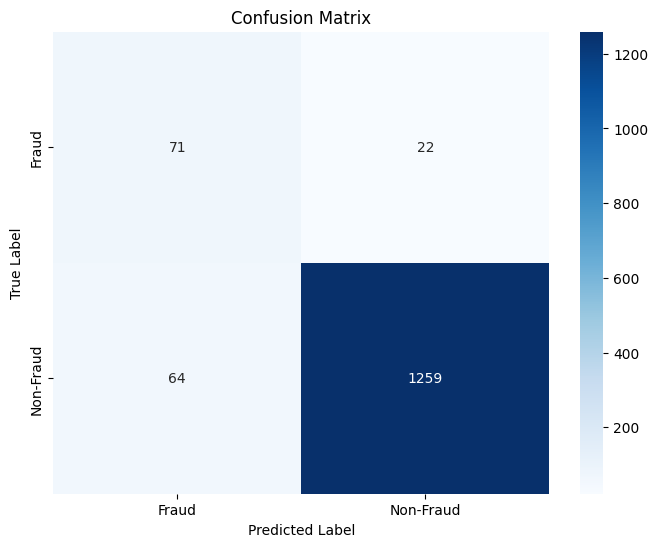


Summary of Findings:
- The ensemble model achieved an accuracy of 0.9393 on the test data.
- The classification report provides detailed metrics (precision, recall, F1-score) for each class.
- The confusion matrix shows the number of true positive, true negative, false positive, and false negative predictions.
- These results can be used to identify potential fraudulent claims for further review.


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Get the true labels from the test dataset
true_labels = np.concatenate([y for x, y in test_ds], axis=0)

# Generate the classification report
report = classification_report(true_labels, predicted_classes, target_names=class_names)
print("Classification Report:\n", report)

# Generate and display the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Summarize findings
print("\nSummary of Findings:")
print(f"- The ensemble model achieved an accuracy of {accuracy:.4f} on the test data.")
print("- The classification report provides detailed metrics (precision, recall, F1-score) for each class.")
print("- The confusion matrix shows the number of true positive, true negative, false positive, and false negative predictions.")
print("- These results can be used to identify potential fraudulent claims for further review.")

In [ ]:
from tensorflow.keras.models import save_model
import os

# Define the file path for saving the model
model_save_path = os.path.join(os.getcwd(), "ensemble_model.keras")  # Save in current working directory

# Save the ensemble model
save_model(ensemble_model, model_save_path)

print(f"Ensemble model saved successfully to {model_save_path}")